Классификация. Задачи: 

1. Из столбца likes сделайте категориальный столбец : mean - среднее значение, likes > 2/3 mean = 1, likes<1/3 mean = -1, else 0

2. Классифицируйте твиты по полученному признаку, выполните предсказание для любых 3 твитов собственного сочинения.

3. Какие слова чаще используются в твитах классов 0, 1, - 1? 

4. Предложите 2 разные модели, для каждой модели вычислите значение метрик и классы придуманных твитов



* выполнить EDA

* предложить 2 эффективных моделей решения (меняйте архитектуры, гиперпараметры, эмбеддинги)

* cравнение моделей необходимо выполнить по метрикам. 

* Привести примеры работы моделей на произвольных данных

Оценка 60
1. EDA–5
2. 1 модель - 10
3. 2 модель - 10
4. Сравнение моделей и рекомендации - 5
5. Создание собственных тестовых примеров - 10
6. Моделирование новых признаков - 5
7. Ответы на вопросы в задании -10
8. Оформление презентации и ноутбука - 5


Сдаете в письме презентацию и ноутбук в архиве zip с Вашей фамилией (блокнот назовите своей фамилией на англ языке)

Дэдлайн: Среда 15:00


In [ ]:
PATH = "../content/drive/My Drive/Нейронные сети 1_Модуль_2020/"

In [ ]:
pip install pywsd

     |████████████████████████████████| 26.8MB 165kB/s 
     |████████████████████████████████| 31.6MB 141kB/s 
  Created wheel for pywsd: filename=pywsd-1.2.4-cp36-none-any.whl size=26940455 sha256=0be68005443e0d67b2f163a199e61a1a36032e409ab5c1bfe23b5e8dfe9e58ed
  Stored in directory: /root/.cache/pip/wheels/71/4d/d2/405b948047f7f3851f16ab9d893ce7c1a3010182900884536b
  Created wheel for wn: filename=wn-0.0.23-cp36-none-any.whl size=31792944 sha256=33fe764b949930587818537885f5d34cb2500b59a455e3e31655243d9d5b9bea
  Stored in directory: /root/.cache/pip/wheels/56/e3/c4/886021dbf4d758dc3cb9ddaa47d7d6fc895240d83f010e6305
Successfully built pywsd wn


In [ ]:
import tensorflow as tf
import keras
from keras import metrics

from tensorflow import sparse 
import gc
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse
from scipy.sparse import csr_matrix, hstack

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

from keras.models import Sequential
from keras import regularizers
from keras import optimizers
from keras.layers import Dense, Dropout, Embedding, Flatten, Lambda

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Для определения, какие слова частые для каждого класса
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Для лемматизации предложения
import pywsd
from pywsd.utils import lemmatize_sentence
import pickle


# для API - Модели 2 с 2мя входами
from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Embedding, Bidirectional, Dense, LSTM, concatenate
from keras import Input 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Warming up PyWSD (takes ~10 secs)... took 5.681649684906006 secs.


In [ ]:
# Введем callback
callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)  
]

In [ ]:
# Информация по фичам (название, кол-во пропущенных значений, число унивкальных значений, питонячий тип)
def get_info(df):
  return pd.DataFrame({'Feature': df.columns.tolist(),
              'NaN_count': df.isna().sum().tolist(),
              'number_of_unique_elements': pd.Series(df.columns.tolist()).apply(lambda row: df[row].nunique()),
              'type': pd.Series(df.columns.tolist()).apply(lambda row: df[row].dtype)
              })

In [ ]:
df = pd.read_csv(PATH+'ex1.csv')

print(df.shape)
df.head()

(5776, 3)


,url,tweet,likes
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",12326
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,24330
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,71698
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",8500
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,16564


In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,url,0,5776,object
1,tweet,0,5774,object
2,likes,0,4684,int64


In [ ]:
# Почистим столбец tweet - оставим только слова, но пока добавим новый столбец
def text_process(text):
       
    tokenized_text = word_tokenize(text, 'english')
    
    # Удаление пунктуации и прочих символов
    no_punctuation = [token for token in tokenized_text if token.isalpha()]
    
    return ' '.join(no_punctuation).lower()

df['tweet_clean'] = df['tweet'].apply(text_process)
df.head()

,url,tweet,likes,tweet_clean
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",12326,folks millions of you have already requested a...
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,24330,violence against transgender and gender people...
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,71698,let s be clear the emergency aid should have n...
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",8500,the election is underway across the country an...
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,16564,not only does president trump refuse to grant ...


In [ ]:
# Из столбца likes делаем категориальный столбец: 
# mean - среднее значение, likes > 2/3 mean = 1, likes<1/3 mean = -1, else 0
df['likes_cat'] = 0
df['likes_cat'].iloc[df['likes'] > (2/3)*np.mean(df['likes'])] = 1 
df['likes_cat'].iloc[df['likes'] < (1/3)*np.mean(df['likes'])] = -1 
print('mean', np.mean(df['likes']))
print('(2/3)mean', (2/3)*np.mean(df['likes']))
print('(1/3)mean', (1/3)*np.mean(df['likes']))
df.head()

mean 32180.896987534627
(2/3)mean 21453.931325023084
(1/3)mean 10726.965662511542


,url,tweet,likes,tweet_clean,likes_cat
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",12326,folks millions of you have already requested a...,0
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,24330,violence against transgender and gender people...,1
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,71698,let s be clear the emergency aid should have n...,1
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",8500,the election is underway across the country an...,-1
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,16564,not only does president trump refuse to grant ...,0


In [ ]:
df = df.drop(columns=['likes'])
df.head()

,url,tweet,tweet_clean,likes_cat
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",folks millions of you have already requested a...,0
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,violence against transgender and gender people...,1
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,let s be clear the emergency aid should have n...,1
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",the election is underway across the country an...,-1
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,not only does president trump refuse to grant ...,0


In [ ]:
# Посмотрим на отдельные значения столбцов
print('url_example: ', df.iloc[100,0])
print('tweet_example: ', df.iloc[100,1])

url_example:  https://twitter.com/JoeBiden/status/1315033249186414592
tweet_example:  I’m in Erie, Pennsylvania, to discuss my plans to build back better. Tune in. https://t.co/8NqGra1egn


##### Добавим новые признаки

Новые признаки из tweet: 
* кол-во слов 
* кол-во предложений 
* кол-во спец символов
* кол-во ссылок на др-ие источники (маска 'https:')
* кол-во ссылок на другие профили (маска "@")
* кол-во хэштегов (маска "#")


In [ ]:
# df.loc[3:5,['url', 'tweet', 'likes_cat']]

In [ ]:
# Кол-во слов
def cnt_words(v_str): 
  cnt = len(v_str.split())
  return cnt

df['cnt_words'] = df['tweet_clean'].apply(cnt_words)

#  Кол-во предложений
def cnt_sentences(v_str):
  cnt = len(nltk.sent_tokenize(v_str))
  return cnt 

df['cnt_snts'] = df['tweet'].apply(cnt_sentences)

# Кол-во спец символов
def cnt_spec_smbls(v_str): 
  tokenized_text = word_tokenize(v_str, 'english')
  no_punctuation = [token for token in tokenized_text if token.isalpha()==False]
  cnt = len(no_punctuation)
  return cnt

df['cnt_spec_smbls'] = df['tweet'].apply(cnt_spec_smbls)

# Кол-во объектов по маске - ссылки на сайты, ссылки на профили, хэштеги 
def cnt_mask_smbls(v_str, mask):
  cnt = len(re.findall(mask,v_str))
  return cnt 

df['cnt_link_web'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'http'),  axis=1)
df['cnt_link_users'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'@'),  axis=1)
df['cnt_tags'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'#'),  axis=1)


df.head()

,url,tweet,tweet_clean,likes_cat,cnt_words,cnt_snts,cnt_spec_smbls,cnt_link_web,cnt_link_users,cnt_tags
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",folks millions of you have already requested a...,0,45,5,12,2,0,0
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,violence against transgender and gender people...,1,36,4,8,1,0,0
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,let s be clear the emergency aid should have n...,1,17,2,5,1,0,0
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",the election is underway across the country an...,-1,33,4,9,1,0,0
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,not only does president trump refuse to grant ...,0,45,3,6,1,0,0


##### Добавим тональность с помощью обученной сетки из ДЗ от 28092020.

In [ ]:
# Загрузка Обученной нейронной сети
model = keras.models.load_model(PATH+'NN_28092020/NN_model_for_short_sntns.h5')

# Загрузка предобработчика предложений для Нейронной сети
with open(PATH+'NN_28092020/vectorizer', 'rb') as f:
    vectorizer = pickle.load(f)


In [ ]:
# Проверим на примере
my_sentences = ['the match was great', 'it is the worst trip in my life']
d = vectorizer.transform(my_sentences).toarray()

result = pd.DataFrame({'sentence': my_sentences, 
                      'result_proba': model.predict(d)[:, 0]
              })
result['result'] = round(result['result_proba'],0)
result['result_name'] = " Позитивное"
result.loc[(result['result'] == 0.0), 'result_name'] = "Негативное"

result

,sentence,result_proba,result,result_name
0,the match was great,0.881213,1.0,Позитивное
1,it is the worst trip in my life,0.136988,0.0,Негативное


In [ ]:
# Новый признак - тональность 
def tonality_predict(sntc):
  sntc = vectorizer.transform([sntc]).toarray()
  ton = round(model.predict(sntc)[0][0],0) # [0][0] так как 2мерный массив, прогноз для 1 предложения
  return ton

df['tonality'] = df['tweet_clean'].apply(tonality_predict)
df['tonality'] = df['tonality'].astype('int')
df.head()


,url,tweet,tweet_clean,likes_cat,cnt_words,cnt_snts,cnt_spec_smbls,cnt_link_web,cnt_link_users,cnt_tags,tonality
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",folks millions of you have already requested a...,0,45,5,12,2,0,0,0
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,violence against transgender and gender people...,1,36,4,8,1,0,0,1
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,let s be clear the emergency aid should have n...,1,17,2,5,1,0,0,0
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",the election is underway across the country an...,-1,33,4,9,1,0,0,1
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,not only does president trump refuse to grant ...,0,45,3,6,1,0,0,0


In [ ]:
# Добавим столбец твитов с Лемматизацией для подсчета слов для каждого класса "likes_cat"
def lemm_tweets(v_str): 
  words_lemm = lemmatize_sentence(v_str)
  return ' '.join(words_lemm)

df['tweet_clean_lem'] = df['tweet_clean'].apply(lemm_tweets)
df.head()

,url,tweet,tweet_clean,likes_cat,cnt_words,cnt_snts,cnt_spec_smbls,cnt_link_web,cnt_link_users,cnt_tags,tonality,tweet_clean_lem
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",folks millions of you have already requested a...,0,45,5,12,2,0,0,0,folk million of you have already request absen...
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,violence against transgender and gender people...,1,36,4,8,1,0,0,1,violence against transgender and gender people...
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,let s be clear the emergency aid should have n...,1,17,2,5,1,0,0,0,let s be clear the emergency aid should have n...
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",the election is underway across the country an...,-1,33,4,9,1,0,0,1,the election be underway across the country an...
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,not only does president trump refuse to grant ...,0,45,3,6,1,0,0,0,not only do president trump refuse to grant te...


In [ ]:
# Сохраним обработанные данные
# df.to_csv(PATH+'df_exam_nn_prepared.csv')

# # Загрузим обработанные данные
df = pd.read_csv(PATH+'df_exam_nn_prepared.csv', index_col=[0])
df.head()


,url,tweet,tweet_clean,likes_cat,cnt_words,cnt_snts,cnt_spec_smbls,cnt_link_web,cnt_link_users,cnt_tags,tonality,tweet_clean_lem
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",folks millions of you have already requested a...,0,45,5,12,2,0,0,0,folk million of you have already request absen...
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,violence against transgender and gender people...,1,36,4,8,1,0,0,1,violence against transgender and gender people...
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,let s be clear the emergency aid should have n...,1,17,2,5,1,0,0,0,let s be clear the emergency aid should have n...
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",the election is underway across the country an...,-1,33,4,9,1,0,0,1,the election be underway across the country an...
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,not only does president trump refuse to grant ...,0,45,3,6,1,0,0,0,not only do president trump refuse to grant te...


## EDA

In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,url,0,5776,object
1,tweet,0,5774,object
2,tweet_clean,0,5745,object
3,likes_cat,0,3,int64
4,cnt_words,0,59,int64
5,cnt_snts,0,9,int64
6,cnt_spec_smbls,0,22,int64
7,cnt_link_web,0,5,int64
8,cnt_link_users,0,8,int64
9,cnt_tags,0,4,int64


-1    3286
 1    1779
 0     711
Name: likes_cat, dtype: int64

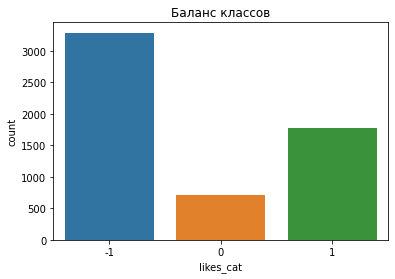

In [ ]:
# Определяем баланс классов
sns.countplot(df['likes_cat'])
plt.title('Баланс классов')
df['likes_cat'].value_counts()

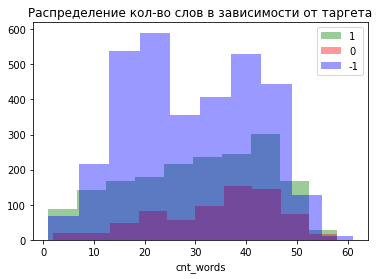

In [ ]:
# Распределение кол-во слов в зависимости от таргета
sns.distplot(df['cnt_words'].loc[df['likes_cat']==1], color='green', bins=10, kde=False)
sns.distplot(df['cnt_words'].loc[df['likes_cat']==0], color='red', bins=10, kde=False)
sns.distplot(df['cnt_words'].loc[df['likes_cat']==-1], color='blue', bins=10, kde=False)
plt.title('Распределение кол-во слов в зависимости от таргета')
plt.legend((1, 0, -1))

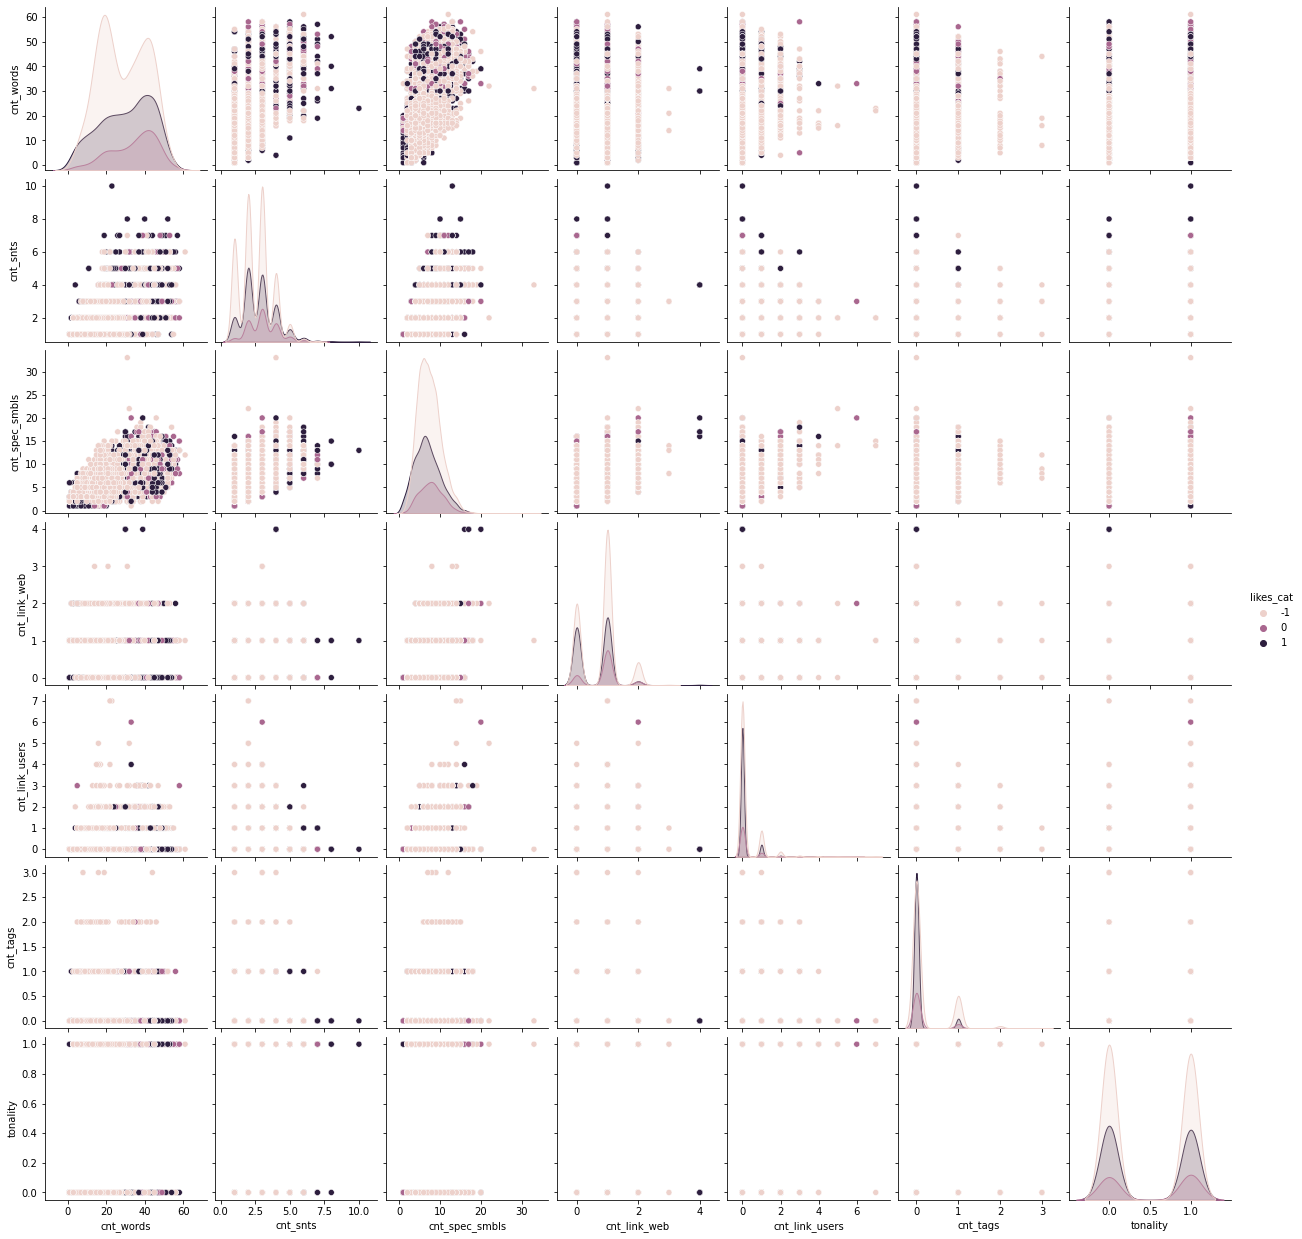

In [ ]:
sns.pairplot(df, hue='likes_cat')

# Самые частые слова, присущие каждому классу

In [ ]:
# Опредеяем стоп-слова
stopwords = set(STOPWORDS)
# Добавим еще служебные слова
stopwords.add('https') 

In [ ]:
# Отрисовка облака слов 
def get_pop_words(class_num,color_name="white"):
  text = " ".join(tweet for tweet in df[df['likes_cat']==class_num]['tweet_clean_lem'])

  print("Кол-во слов (класс "+str(class_num)+"): ",len(text))


  wordcloud = WordCloud(stopwords=stopwords,
                        background_color=color_name,
                        width = 1920,
                        height = 1080).generate(text)
  plt.figure(figsize = (20, 10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title('Облако слов для класса '+str(class_num))
  plt.axis("off")
  plt.show()

##### Опеределим все частые слова в классе 0

Кол-во слов (класс 0):  127641


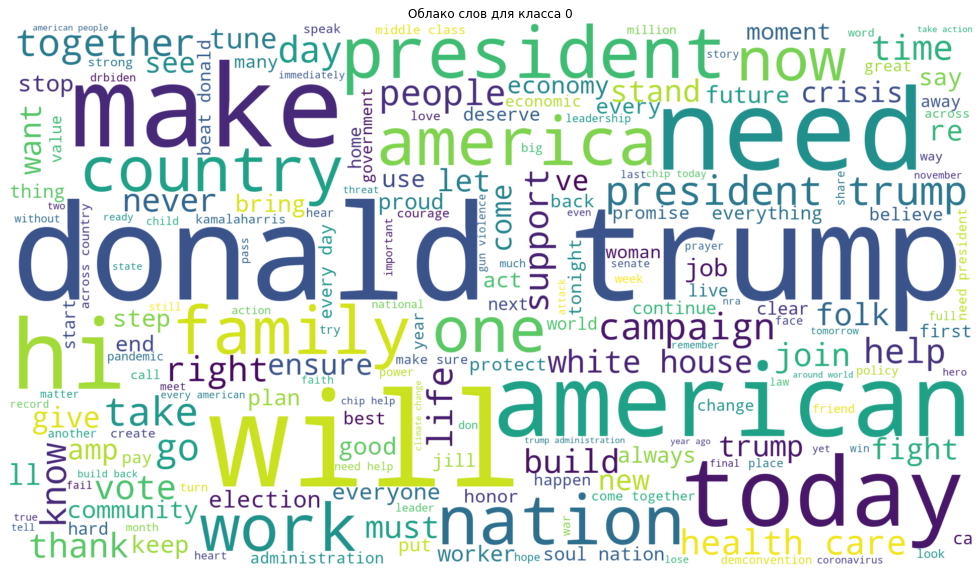

In [ ]:
get_pop_words(0)

##### переделим все частые слова в классе 1

Кол-во слов (класс 1):  281465


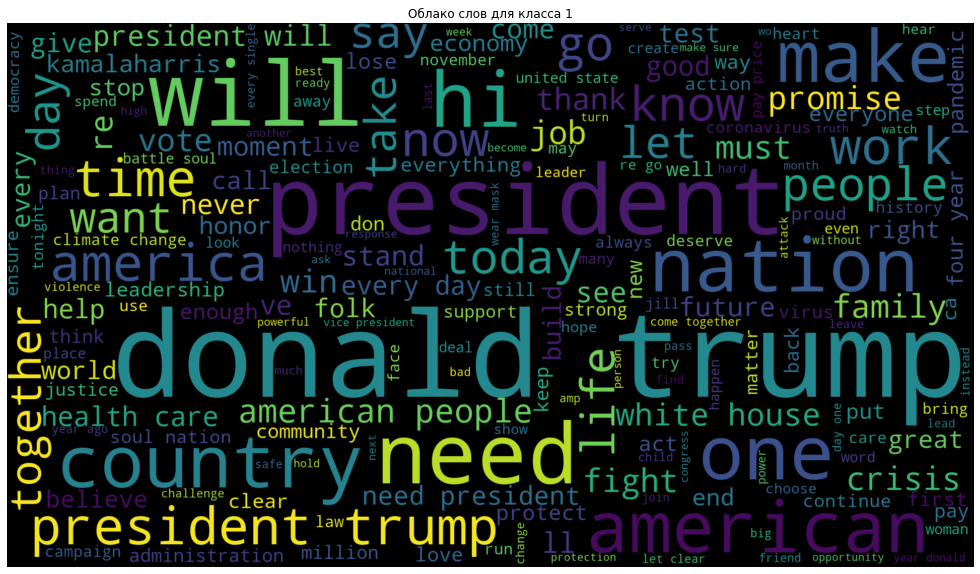

In [ ]:
get_pop_words(1, "black")

##### переделим все частые слова в классе -1

Кол-во слов (класс -1):  504127


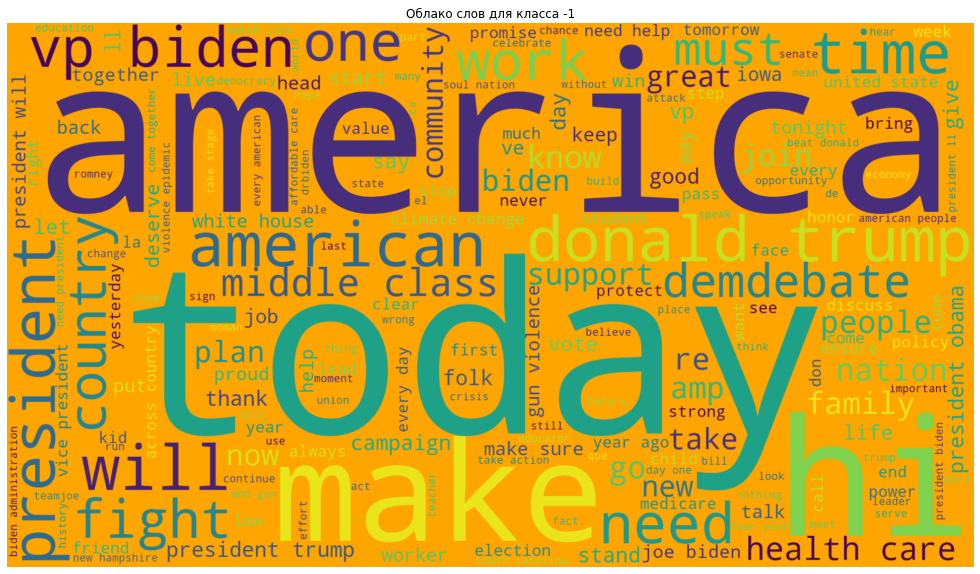

In [ ]:
get_pop_words(-1, "orange")

# Предобработка данных для модели

In [ ]:
# Загрузим обработанные данные
df = pd.read_csv(PATH+'df_exam_nn_prepared.csv', index_col=[0])
df.head()

,url,tweet,tweet_clean,likes_cat,cnt_words,cnt_snts,cnt_spec_smbls,cnt_link_web,cnt_link_users,cnt_tags,tonality,tweet_clean_lem
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",folks millions of you have already requested a...,0,45,5,12,2,0,0,0,folk million of you have already request absen...
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,violence against transgender and gender people...,1,36,4,8,1,0,0,1,violence against transgender and gender people...
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,let s be clear the emergency aid should have n...,1,17,2,5,1,0,0,0,let s be clear the emergency aid should have n...
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",the election is underway across the country an...,-1,33,4,9,1,0,0,1,the election be underway across the country an...
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,not only does president trump refuse to grant ...,0,45,3,6,1,0,0,0,not only do president trump refuse to grant te...


In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,url,0,5776,object
1,tweet,0,5774,object
2,tweet_clean,0,5745,object
3,likes_cat,0,3,int64
4,cnt_words,0,59,int64
5,cnt_snts,0,9,int64
6,cnt_spec_smbls,0,22,int64
7,cnt_link_web,0,5,int64
8,cnt_link_users,0,8,int64
9,cnt_tags,0,4,int64


In [ ]:
# Удалим лишние признаки 
df = df.drop(columns=['url', 'tweet'])
get_info(df)

In [ ]:
# Попробуем сделать модели с лемматизацией и без

# обычные фичи 
X = df.drop(columns=['likes_cat', 'tweet_clean','tweet_clean_lem'])

# Таргет
y = df['likes_cat'].values

# отдельно твиты, так как нужно еще их векторизовать
## обычные 
tweets = df['tweet_clean'].values

## лематизированные
tweets_lem = df['tweet_clean_lem'].values

get_info(X)

,Feature,NaN_count,number_of_unique_elements,type
0,cnt_words,0,59,int64
1,cnt_snts,0,9,int64
2,cnt_spec_smbls,0,22,int64
3,cnt_link_web,0,5,int64
4,cnt_link_users,0,8,int64
5,cnt_tags,0,4,int64
6,tonality,0,2,int64


In [ ]:
X.head()

,cnt_words,cnt_snts,cnt_spec_smbls,cnt_link_web,cnt_link_users,cnt_tags,tonality
0,45,5,12,2,0,0,0
1,36,4,8,1,0,0,1
2,17,2,5,1,0,0,0
3,33,4,9,1,0,0,1
4,45,3,6,1,0,0,0


In [ ]:
# Векторизуем твиты
## обычные 
vectorizer = CountVectorizer()
vectorized_tweets = vectorizer.fit_transform(tweets)

# # Сохраним векторизатор
# with open(PATH+'/exam/model_1/vectorizer', 'wb') as fout:
#     pickle.dump(vectorizer, fout)

## с лемматизацией 
lem_vectorizer = CountVectorizer()
vectorized_tweets_lem = lem_vectorizer.fit_transform(tweets_lem)

# # Сохраним векторизатор
# with open(PATH+'/exam/model_1/lem_vectorizer', 'wb') as fout:
#     pickle.dump(lem_vectorizer, fout)


In [ ]:
# Масштабируем фичи 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Сохраним стандартизатор
# with open(PATH+'/exam/scaler', 'wb') as fout:
#     pickle.dump(scaler, fout)

In [ ]:
X_std.shape

(5776, 7)

In [ ]:
vectorized_tweets.shape

(5776, 8778)

In [ ]:
vectorized_tweets_lem.shape

(5776, 7103)

In [ ]:
# Соединим в один массив
## обычные 
X_all = hstack([X_std, vectorized_tweets])
print(X_all.shape)
## c лемматизацией
X_all_lem = hstack([X_std, vectorized_tweets_lem])
print(X_all_lem.shape)

(5776, 8785)
(5776, 7110)


In [ ]:
X_all

<5776x8785 sparse matrix of type '<class 'numpy.float64'>'
	with 184534 stored elements in COOrdinate format>

##### Сохранение данных для модели 

In [ ]:
# scipy.sparse.save_npz(PATH+'/exam/model_1/X_all.npz', X_all)
# scipy.sparse.save_npz(PATH+'/exam/model_1/X_all_lem.npz', X_all_lem)

#### Загрузка данных для модели

In [ ]:
# Фичи
X_all = scipy.sparse.load_npz(PATH+'/exam/model_1/X_all.npz')
X_all_lem = scipy.sparse.load_npz(PATH+'/exam/model_1/X_all_lem.npz')

# Таргет 
df = pd.read_csv(PATH+'df_exam_nn_prepared.csv', index_col=[0])

y = df['likes_cat'].values

del df

#### Деление на train test

In [ ]:
# Поделим на train и test

## обычные 
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size = 0.2, random_state=17)

## c лемматизацией
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_all_lem, y, test_size = 0.2, random_state=17)


In [ ]:
print(X_train.shape, X_test.shape)

(4620, 8785) (1156, 8785)


In [ ]:
print(X_train_lem.shape, X_test_lem.shape)

(4620, 7110) (1156, 7110)


In [ ]:
print(y_train.shape, y_test.shape)

(4620,) (1156,)


# Построение моделей

## Модель 1

In [ ]:
# Введем callback
callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='accuracy', patience=2),
        keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10)  
]

#loss,accuracy

In [ ]:
def learn_nn_model1(X_train, y_train, X_test, y_test):
  # Размерность входа
  input_dim = X_train.shape[1]

  # Y - надо закодировать 
  y_train_dummy = pd.get_dummies(y_train).values
  y_test_dummy = pd.get_dummies(y_test).values

  # Архитектура сети
  model1 = Sequential()
  model1.add(Dense(10000, 
                   input_dim=input_dim,
                   activation='relu'))
  model1.add(Dense(5000, activation='relu'))
  model1.add(Dropout(0.35))
  model1.add(Dense(1000, activation='relu'))
  model1.add(Dropout(0.2))
  model1.add(Dense(100, activation='relu'))
  model1.add(Dense(3, activation='softmax'))

  model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  history = model1.fit(X_train, y_train_dummy, 
                      epochs=50,
                      verbose=True,
                      validation_data=(X_test, 
                                       y_test_dummy
                                       ),
                      batch_size=100,
                      callbacks=callbacks_list
                      )
  # Оценка модели на тесте 
  score = model1.evaluate(X_test, 
                          y_test_dummy,
                          verbose=0)
  print('Accuracy (test data): ', score[1])
  
  # Графики
  ## Точность 
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy']) 
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  ## Потери 
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])  
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  

  # Confusion matrix

   # model1.predict - вероятности отнесения к классу 
   # Нужен выбор класса с большей вероятностью, но в формате "-1, 0, 1", а не "0, 1, 2"

  df = pd.DataFrame({'actual': y_test,
                     'predicted': np.argmax(model1.predict(X_test),1)
                    })

  df['predcited_like_test'] = -1 
  df['predcited_like_test'].iloc[df['predicted']==1] = 0
  df['predcited_like_test'].iloc[df['predicted']==2] = 1

  mat = confusion_matrix(df['actual'].values, # Decode labels #Y_test, 
                        df['predcited_like_test'].values # Decode Predicted labels #Y_pred
                        ) 

  # Plot Confusion matrix
  sns.heatmap(mat.T, square=True, annot=True, cbar=False, 
              cmap=plt.cm.Blues, xticklabels=[-1,0,1], yticklabels=[-1,0,1])

  plt.xlabel('Predicted Values')
  plt.ylabel('True Values')
  plt.title('Confusion matrix')
  plt.show()

  return model1

#### без лемматизации

In [ ]:
model1 = learn_nn_model1(X_train, y_train, X_test, y_test)

In [ ]:
# Сохраним 1ую модель без лемматизации
# model1.save(PATH+'/exam/model_1/NN_exam_model1.h5')

#### с лемматизацией

Epoch 1/50
47/47 [==============================] - 56s 1s/step - loss: 0.8844 - accuracy: 0.6219 - val_loss: 0.7100 - val_accuracy: 0.6903
Epoch 2/50
47/47 [==============================] - 52s 1s/step - loss: 0.4414 - accuracy: 0.8177 - val_loss: 0.8266 - val_accuracy: 0.6817
Epoch 3/50
47/47 [==============================] - 51s 1s/step - loss: 0.1775 - accuracy: 0.9361 - val_loss: 1.1212 - val_accuracy: 0.6704
Epoch 4/50
47/47 [==============================] - 51s 1s/step - loss: 0.0762 - accuracy: 0.9773 - val_loss: 1.3254 - val_accuracy: 0.6505
Epoch 5/50
47/47 [==============================] - 51s 1s/step - loss: 0.0519 - accuracy: 0.9851 - val_loss: 1.3072 - val_accuracy: 0.6843
Epoch 6/50
47/47 [==============================] - 52s 1s/step - loss: 0.0263 - accuracy: 0.9939 - val_loss: 1.5097 - val_accuracy: 0.6938
Epoch 7/50
47/47 [==============================] - 51s 1s/step - loss: 0.0175 - accuracy: 0.9961 - val_loss: 1.5904 - val_accuracy: 0.6817
Epoch 8/50
47/47 [==

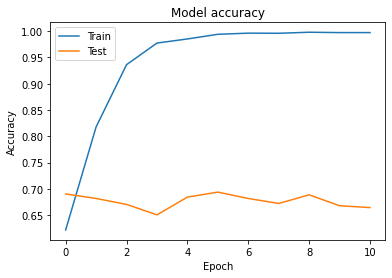

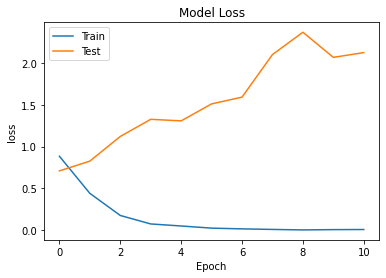

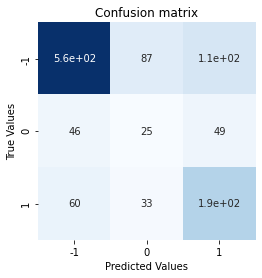

In [ ]:
model1 = learn_nn_model1(X_train_lem, y_train_lem, X_test_lem, y_test_lem)

In [ ]:
# Сохраним 1ую модель с лемматизации
# model1.save(PATH+'/exam/model_1/NN_exam_model1_lem.h5')

##  Прогноз на своих примерах

#### Пример из датасэта

In [ ]:
# Загрузка Обученной нейронной сети
# model1 = keras.models.load_model(PATH+'/exam/model_1/NN_exam_model1.h5')

In [ ]:
# Будем в качестве примеров брать несколько строк - при проверке моделей впишем туда свои значения 
exmpl = pd.read_csv(PATH+'ex1.csv').loc[0:2, :]

mean_likes = 32180.896987534627

# mean - среднее значение, likes > 2/3 mean = 1, likes<1/3 mean = -1, else 0
exmpl['Actual'] = 0
exmpl['Actual'].iloc[exmpl['likes'] > (2/3)*mean_likes] = 1 
exmpl['Actual'].iloc[exmpl['likes'] < (1/3)*mean_likes] = -1 

exmpl

,url,tweet,likes,Actual
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",12326,0
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,24330,1
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,71698,1


In [ ]:
# Обработка вх. данных
def preprocessing_data(df, tweet_lemmatize=False):

  '''
  df - фичи 
  '''

  # Почистим столбец tweet - оставим только слова, но пока добавим новый столбец
  def text_process(text):
        
      tokenized_text = word_tokenize(text, 'english')
      
      # Удаление пунктуации и прочих символов
      no_punctuation = [token for token in tokenized_text if token.isalpha()]
      
      return ' '.join(no_punctuation).lower()

  df['tweet_clean'] = df['tweet'].apply(text_process)

  # Кол-во слов
  def cnt_words(v_str): 
    cnt = len(v_str.split())
    return cnt

  df['cnt_words'] = df['tweet_clean'].apply(cnt_words)

  #  Кол-во предложений
  def cnt_sentences(v_str):
    cnt = len(nltk.sent_tokenize(v_str))
    return cnt 

  df['cnt_snts'] = df['tweet'].apply(cnt_sentences)

  # Кол-во спец символов
  def cnt_spec_smbls(v_str): 
    tokenized_text = word_tokenize(v_str, 'english')
    no_punctuation = [token for token in tokenized_text if token.isalpha()==False]
    cnt = len(no_punctuation)
    return cnt

  df['cnt_spec_smbls'] = df['tweet'].apply(cnt_spec_smbls)

  # Кол-во объектов по маске - ссылки на сайты, ссылки на профили, хэштеги 
  def cnt_mask_smbls(v_str, mask):
    cnt = len(re.findall(mask,v_str))
    return cnt 

  df['cnt_link_web'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'http'),  axis=1)
  df['cnt_link_users'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'@'),  axis=1)
  df['cnt_tags'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'#'),  axis=1)

  # Загрузка Обученной нейронной сети
  model = keras.models.load_model(PATH+'NN_28092020/NN_model_for_short_sntns.h5')

  # Загрузка предобработчика предложений для Нейронной сети
  with open(PATH+'NN_28092020/vectorizer', 'rb') as f:
      tone_vectorizer = pickle.load(f)

  # Новый признак - тональность 
  def tonality_predict(sntc):
    sntc = tone_vectorizer.transform([sntc]).toarray()
    ton = round(model.predict(sntc)[0][0],0) # [0][0] так как 2мерный массив, прогноз для 1 предложения
    return ton

  df['tonality'] = df['tweet_clean'].apply(tonality_predict)
  df['tonality'] = df['tonality'].astype('int')
  df.head()

  if tweet_lemmatize: 
    # Добавим столбец твитов с Лемматизацией для подсчета слов для каждого класса "likes_cat"
    def lemm_tweets(v_str): 
      words_lemm = lemmatize_sentence(v_str)
      return ' '.join(words_lemm)

    df['tweet_clean'] = df['tweet_clean'].apply(lemm_tweets)

  # отдельно твиты, так как нужно еще их векторизовать
  ## обычные 
  tweets = df['tweet_clean'].values

  # Отдельно остальные фичи
  df = df.drop(columns=['url', 'tweet', 'tweet_clean'])

  # Загрузим Векторизатор 
  if tweet_lemmatize: 
    vectorizer_name = 'lem_vectorizer'
  else: 
    vectorizer_name = 'vectorizer'

  with open(PATH+'exam/model_1/'+vectorizer_name, 'rb') as f:
      vectorizer = pickle.load(f)
  
  vectorized_tweets = vectorizer.transform(tweets)

  # Загрузим стандартизатор
  with open(PATH+'exam/scaler', 'rb') as f:
      scaler = pickle.load(f) 

  df_std = scaler.transform(df)

  df_all = scipy.sparse.csr_matrix(hstack([df_std, vectorized_tweets]))

  return df_all

In [ ]:
X_exmpl = preprocessing_data(exmpl.drop(columns=['likes', 'Actual']))

In [ ]:
print(X_train.shape)
print(type(X_train))

(4620, 8785)
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
print(X_exmpl.shape)
print(type(X_exmpl))

(3, 8785)
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
exmpl['predicted'] = np.argmax(model1.predict(X_exmpl),1)

exmpl['predcited_like_test'] = -1 
exmpl['predcited_like_test'].iloc[exmpl['predicted']==1] = 0
exmpl['predcited_like_test'].iloc[exmpl['predicted']==2] = 1

exmpl

,url,tweet,likes,Actual,predicted,predcited_like_test
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",12326,0,1,0
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,24330,1,2,1
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,71698,1,2,1


 #### Свежие твиты Джо Байдена

In [ ]:
def get_predict(exmpl):
  """
  Функция делает прогноз, загружая сеть, 
  на входных данных формата: URL, Tweet, Likes
  """

  mean_likes = 32180.896987534627

  # mean - среднее значение, likes > 2/3 mean = 1, likes<1/3 mean = -1, else 0
  exmpl['Actual'] = 0
  exmpl['Actual'].iloc[exmpl['likes'] > (2/3)*mean_likes] = 1 
  exmpl['Actual'].iloc[exmpl['likes'] < (1/3)*mean_likes] = -1

  # Предобработка данных 
  X_exmpl = preprocessing_data(exmpl.drop(columns=['likes', 'Actual']))

  # Загрузка Обученной нейронной сети
  model1 = keras.models.load_model(PATH+'/exam/model_1/NN_exam_model1.h5')

  # Прогноз и вывод рез-ты 
  exmpl['predicted'] = np.argmax(model1.predict(X_exmpl),1)

  exmpl['predcited_like_test'] = -1 
  exmpl['predcited_like_test'].iloc[exmpl['predicted']==1] = 0
  exmpl['predcited_like_test'].iloc[exmpl['predicted']==2] = 1

  exmpl.drop(columns=['predicted'], inplace=True)

  return exmpl

In [ ]:
# новые твиты
new_url = ['https://twitter.com/JoeBiden/status/1320857739959193601', 
           'https://twitter.com/JoeBiden/status/1320850190325194754',
           'https://twitter.com/JoeBiden/status/1320836600805416961']

new_tweet = ["Folks, I'm amazed by what you all are doing to get out the vote. We can't let up — remember to vote early, and sign up to help this final weekend: http://joebiden.com/gotv",
             "I couldn't be more excited to have my friend @BarackObama hitting the campaign trail to talk about what's at stake in this election. As he said in Philadelphia, we can't just imagine a better future — we have to fight for it and vote like never before: http://iwillvote.com", 
             "We can’t let President Trump tear down Obamacare."]
             
new_likes = [22000, 28800, 131100]

new_exmpl = pd.DataFrame({
 'url': new_url,
 'tweet': new_tweet, 
  'likes': new_likes    
})

new_exmpl

,url,tweet,likes
0,https://twitter.com/JoeBiden/status/1320857739...,"Folks, I'm amazed by what you all are doing to...",22000
1,https://twitter.com/JoeBiden/status/1320850190...,I couldn't be more excited to have my friend @...,28800
2,https://twitter.com/JoeBiden/status/1320836600...,We can’t let President Trump tear down Obamacare.,131100


In [ ]:
get_predict(new_exmpl) 

,url,tweet,likes,Actual,predcited_like_test
0,https://twitter.com/JoeBiden/status/1320857739...,"Folks, I'm amazed by what you all are doing to...",22000,1,-1
1,https://twitter.com/JoeBiden/status/1320850190...,I couldn't be more excited to have my friend @...,28800,1,-1
2,https://twitter.com/JoeBiden/status/1320836600...,We can’t let President Trump tear down Obamacare.,131100,1,1


## Модель 2

https://mmuratarat.github.io/2019-06-12/embeddings-with-numeric-variables-Keras

https://medium.com/@djajafer/multi-class-text-classification-with-keras-and-lstm-4c5525bef592

https://towardsdatascience.com/combining-numerical-and-text-features-in-deep-neural-networks-e91f0237eea4

In [ ]:
# Загрузим обработанные данные
df = pd.read_csv(PATH+'df_exam_nn_prepared.csv', index_col=[0])
df.head(3)

,url,tweet,tweet_clean,likes_cat,cnt_words,cnt_snts,cnt_spec_smbls,cnt_link_web,cnt_link_users,cnt_tags,tonality,tweet_clean_lem
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",folks millions of you have already requested a...,0,45,5,12,2,0,0,0,folk million of you have already request absen...
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,violence against transgender and gender people...,1,36,4,8,1,0,0,1,violence against transgender and gender people...
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,let s be clear the emergency aid should have n...,1,17,2,5,1,0,0,0,let s be clear the emergency aid should have n...


In [ ]:
# Опредеяем стоп-слова
stopwords = set(STOPWORDS)
# Добавим еще служебные слова
stopwords.add('https')

def del_stopwords(v_str): 
  word_list = v_str.split()
  word_list = [i for i in word_list if i not in stopwords]
  return ' '.join(word_list)


df['tweet_lem_del_stopwords'] = df['tweet_clean_lem'].apply(del_stopwords)
df.head()


,url,tweet,tweet_clean,likes_cat,cnt_words,cnt_snts,cnt_spec_smbls,cnt_link_web,cnt_link_users,cnt_tags,tonality,tweet_clean_lem,tweet_lem_del_stopwords
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",folks millions of you have already requested a...,0,45,5,12,2,0,0,0,folk million of you have already request absen...,folk million already request absentee ballot s...
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,violence against transgender and gender people...,1,36,4,8,1,0,0,1,violence against transgender and gender people...,violence transgender gender people particularl...
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,let s be clear the emergency aid should have n...,1,17,2,5,1,0,0,0,let s be clear the emergency aid should have n...,let s clear emergency aid never deny first place
3,https://twitter.com/JoeBiden/status/1317230581...,"The election is underway across the country, a...",the election is underway across the country an...,-1,33,4,9,1,0,0,1,the election be underway across the country an...,election underway across country million ameri...
4,https://twitter.com/JoeBiden/status/1317226311...,Not only does President Trump refuse to grant ...,not only does president trump refuse to grant ...,0,45,3,6,1,0,0,0,not only do president trump refuse to grant te...,president trump refuse grant temporary protect...


In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,url,0,5776,object
1,tweet,0,5774,object
2,tweet_clean,0,5745,object
3,likes_cat,0,3,int64
4,cnt_words,0,59,int64
5,cnt_snts,0,9,int64
6,cnt_spec_smbls,0,22,int64
7,cnt_link_web,0,5,int64
8,cnt_link_users,0,8,int64
9,cnt_tags,0,4,int64


In [ ]:
# Удалим лишние признаки - работаем с "tweet_lem_del_stopwords"
df = df.drop(columns=['url', 'tweet', 'tweet_clean', 'tweet_clean_lem'])
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,likes_cat,0,3,int64
1,cnt_words,0,59,int64
2,cnt_snts,0,9,int64
3,cnt_spec_smbls,0,22,int64
4,cnt_link_web,0,5,int64
5,cnt_link_users,0,8,int64
6,cnt_tags,0,4,int64
7,tonality,0,2,int64
8,tweet_lem_del_stopwords,0,5728,object


In [ ]:
# Все фичи
X = df.drop(columns=['likes_cat'])

# Таргет
y = df['likes_cat'].values

In [ ]:
# Поделим на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=17)

In [ ]:
# твиты 
tweets_train = X_train['tweet_lem_del_stopwords'].values
tweets_test = X_test['tweet_lem_del_stopwords'].values

# фичи 
X_train_ftrs = X_train.drop(columns=['tweet_lem_del_stopwords'])
X_test_ftrs = X_test.drop(columns=['tweet_lem_del_stopwords'])

In [ ]:
# Стандартизируем числовые признаки
# Загрузим стандартизатор
with open(PATH+'exam/scaler', 'rb') as f:
    scaler = pickle.load(f) 

X_train_ftrs_std = pd.DataFrame(scaler.transform(X_train_ftrs), columns=X_train_ftrs.columns) 
X_test_ftrs_std = pd.DataFrame(scaler.transform(X_test_ftrs), columns=X_test_ftrs.columns) 

In [ ]:
# Токенизируем твиты
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tweets_train)

tweets_train = tokenizer.texts_to_sequences(tweets_train)
tweets_test = tokenizer.texts_to_sequences(tweets_test)

vocab_size = len(tokenizer.word_index) + 1 

# # Сохраним Токенайзер
# with open(PATH+'/exam/model_2/tokenizer', 'wb') as fout:
#     pickle.dump(tokenizer, fout)

In [ ]:
maxlen = 200

tweets_train = pad_sequences(tweets_train, padding='post', maxlen=maxlen)
tweets_test = pad_sequences(tweets_test, padding='post', maxlen=maxlen)

print(tweets_train[0, :])

[52 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


In [ ]:
# Сохраним подготовленные данные 
# with open(PATH+'/exam/model_2/X_train_ftrs_std', 'wb') as fout:
#     pickle.dump(X_train_ftrs_std, fout)

# with open(PATH+'/exam/model_2/X_test_ftrs_std', 'wb') as fout:
#     pickle.dump(X_test_ftrs_std, fout)
    
# with open(PATH+'/exam/model_2/tweets_train', 'wb') as fout:
#     pickle.dump(tweets_train, fout)

# with open(PATH+'/exam/model_2/tweets_test', 'wb') as fout:
#     pickle.dump(tweets_test, fout)


### Сеть 2 

In [ ]:
#### модель с несколькими входами 
def learn_nn_model2(X_train_ftrs_std, text_train, y_train, X_test_ftrs_std, text_test, y_test):
  
  # Размерность входа
  input_dim = X_train.shape[1]

  # Y - надо закодировать 
  y_train_dummy = pd.get_dummies(y_train).values
  y_test_dummy = pd.get_dummies(y_test).values

  # Архитектура сети
  embedding_dim = 50

  # слой для обработки текста
  nlp_input = Input(shape=(maxlen,)) 
  # слой для обработки числовой
  meta_input = Input(shape=(7,))
  # другие слои 
  emb = Embedding(output_dim=embedding_dim, 
                  input_dim=vocab_size, 
                  input_length=maxlen)(nlp_input) 
  nlp_out = Bidirectional(LSTM(128))(emb) 
  concat = concatenate([nlp_out, meta_input]) 
  classifier = Dense(32, activation='relu')(concat) 
  output = Dense(3, activation='softmax')(classifier) 
  # объявление модели
  model = Model(inputs=[nlp_input , meta_input], outputs=[output])

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit([text_train, X_train_ftrs_std], y_train_dummy,
                      verbose=True,
                      epochs=50, 
                      validation_data=([text_test, X_test_ftrs_std], y_test_dummy), 
                      batch_size=100,
                      callbacks=callbacks_list)

  # Оценка модели на тесте 
  score = model.evaluate([text_test, X_test_ftrs_std], y_test_dummy, verbose=0)
  print('Accuracy (test data): ', score[1])

  # Графики
  ## Точность 
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy']) 
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  ## Потери 
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])  
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
  # Confusion matrix

   # model.predict - вероятности отнесения к классу 
   # Нужен выбор класса с большей вероятностью, но в формате "-1, 0, 1", а не "0, 1, 2"

  df = pd.DataFrame({'actual': y_test,
                     'predicted': np.argmax(model.predict([text_test, X_test_ftrs_std]),1)
                    })

  df['predcited_like_test'] = -1 
  df['predcited_like_test'].iloc[df['predicted']==1] = 0
  df['predcited_like_test'].iloc[df['predicted']==2] = 1

  mat = confusion_matrix(df['actual'].values, # Decode labels #Y_test, 
                        df['predcited_like_test'].values # Decode Predicted labels #Y_pred
                        ) 

  # Plot Confusion matrix
  sns.heatmap(mat.T, square=True, annot=True, cbar=False, 
              cmap=plt.cm.Blues, xticklabels=[-1,0,1], yticklabels=[-1,0,1])

  plt.xlabel('Predicted Values')
  plt.ylabel('True Values')
  plt.title('Confusion matrix')
  plt.show()

  return model

Epoch 1/50
47/47 [==============================] - 48s 1s/step - loss: 0.9464 - accuracy: 0.5509 - val_loss: 0.8798 - val_accuracy: 0.5830
Epoch 2/50
47/47 [==============================] - 46s 971ms/step - loss: 0.7723 - accuracy: 0.6608 - val_loss: 0.7338 - val_accuracy: 0.6825
Epoch 3/50
47/47 [==============================] - 45s 963ms/step - loss: 0.6199 - accuracy: 0.7448 - val_loss: 0.7504 - val_accuracy: 0.6903
Epoch 4/50
47/47 [==============================] - 45s 967ms/step - loss: 0.5111 - accuracy: 0.7864 - val_loss: 0.8050 - val_accuracy: 0.6851
Epoch 5/50
47/47 [==============================] - 45s 956ms/step - loss: 0.4348 - accuracy: 0.8268 - val_loss: 0.8642 - val_accuracy: 0.6834
Accuracy (test data):  0.6833909749984741


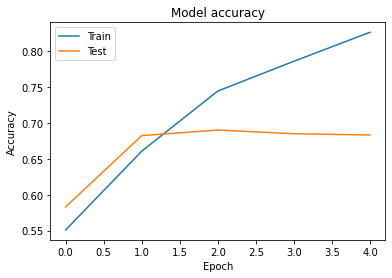

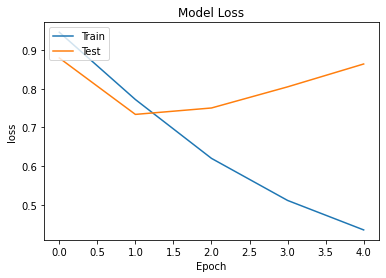

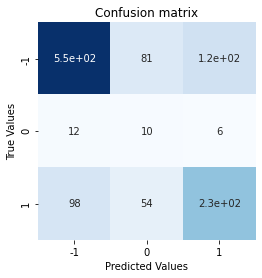

In [ ]:
model2 = learn_nn_model2(X_train_ftrs_std, tweets_train, y_train, X_test_ftrs_std, tweets_test, y_test)

In [ ]:
# Сохраним 2ую модель с лемматизации
# model2.save(PATH+'/exam/model_2/NN_exam_model2.h5')

## Прогноз на своих примерах

#### Пример из датасэта

In [ ]:
# Загрузка Обученной нейронной сети
model2 = keras.models.load_model(PATH+'/exam/model_2/NN_exam_model2.h5')

In [ ]:
# Будем в качестве примеров брать несколько строк - при проверке моделей впишем туда свои значения 
exmpl = pd.read_csv(PATH+'ex1.csv').loc[0:2, :]

mean_likes = 32180.896987534627

# mean - среднее значение, likes > 2/3 mean = 1, likes<1/3 mean = -1, else 0
exmpl['Actual'] = 0
exmpl['Actual'].iloc[exmpl['likes'] > (2/3)*mean_likes] = 1 
exmpl['Actual'].iloc[exmpl['likes'] < (1/3)*mean_likes] = -1 

exmpl

,url,tweet,likes,Actual
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",12326,0
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,24330,1
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,71698,1


In [ ]:
# Обработка вх. данных
def preprocessing_data_model_2(df):

  '''
  df - фичи 
  '''

  # Почистим столбец tweet - оставим только слова, но пока добавим новый столбец
  def text_process(text):
        
      tokenized_text = word_tokenize(text, 'english')
      
      # Удаление пунктуации и прочих символов
      no_punctuation = [token for token in tokenized_text if token.isalpha()]
      
      return ' '.join(no_punctuation).lower()

  df['tweet_clean'] = df['tweet'].apply(text_process)

  # Кол-во слов
  def cnt_words(v_str): 
    cnt = len(v_str.split())
    return cnt

  df['cnt_words'] = df['tweet_clean'].apply(cnt_words)

  #  Кол-во предложений
  def cnt_sentences(v_str):
    cnt = len(nltk.sent_tokenize(v_str))
    return cnt 

  df['cnt_snts'] = df['tweet'].apply(cnt_sentences)

  # Кол-во спец символов
  def cnt_spec_smbls(v_str): 
    tokenized_text = word_tokenize(v_str, 'english')
    no_punctuation = [token for token in tokenized_text if token.isalpha()==False]
    cnt = len(no_punctuation)
    return cnt

  df['cnt_spec_smbls'] = df['tweet'].apply(cnt_spec_smbls)

  # Кол-во объектов по маске - ссылки на сайты, ссылки на профили, хэштеги 
  def cnt_mask_smbls(v_str, mask):
    cnt = len(re.findall(mask,v_str))
    return cnt 

  df['cnt_link_web'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'http'),  axis=1)
  df['cnt_link_users'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'@'),  axis=1)
  df['cnt_tags'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'#'),  axis=1)

  # Загрузка Обученной нейронной сети
  model = keras.models.load_model(PATH+'NN_28092020/NN_model_for_short_sntns.h5')

  # Загрузка предобработчика предложений для Нейронной сети
  with open(PATH+'NN_28092020/vectorizer', 'rb') as f:
      tone_vectorizer = pickle.load(f)

  # Новый признак - тональность 
  def tonality_predict(sntc):
    sntc = tone_vectorizer.transform([sntc]).toarray()
    ton = round(model.predict(sntc)[0][0],0) # [0][0] так как 2мерный массив, прогноз для 1 предложения
    return ton

  df['tonality'] = df['tweet_clean'].apply(tonality_predict)
  df['tonality'] = df['tonality'].astype('int')
  df.head()

  # Добавим столбец твитов с Лемматизацией для подсчета слов для каждого класса "likes_cat"
  def lemm_tweets(v_str): 
    words_lemm = lemmatize_sentence(v_str)
    return ' '.join(words_lemm)

  df['tweet_clean_lem'] = df['tweet_clean'].apply(lemm_tweets)
    
  # Опредеяем стоп-слова
  stopwords = set(STOPWORDS)
  # Добавим еще служебные слова
  stopwords.add('https')

  def del_stopwords(v_str): 
    word_list = v_str.split()
    word_list = [i for i in word_list if i not in stopwords]
    return ' '.join(word_list)

  df['tweet_lem_del_stopwords'] = df['tweet_clean_lem'].apply(del_stopwords)

  # Удалим лишние признаки - работаем с "tweet_lem_del_stopwords"
  df = df.drop(columns=['url', 'tweet', 'tweet_clean', 'tweet_clean_lem'])

  # отдельно твиты 
  tweets = df['tweet_lem_del_stopwords'].values

  # Отдельно остальные фичи 
  ftrs = df.drop(columns=['tweet_lem_del_stopwords'])

  # Загрузим Токенизатор 
  with open(PATH+'exam/model_2/tokenizer', 'rb') as f:
      tokenizer = pickle.load(f)
  
  tokenizer.fit_on_texts(tweets)
  tweets = tokenizer.texts_to_sequences(tweets)
  vocab_size = len(tokenizer.word_index) + 1 

  maxlen = 200
  tweets = pad_sequences(tweets, padding='post', maxlen=maxlen)
 
  # Загрузим стандартизатор
  with open(PATH+'exam/scaler', 'rb') as f:
      scaler = pickle.load(f) 

  ftrs_std = scaler.transform(ftrs)

  return [tweets, ftrs_std]

In [ ]:
exmpl_data_list = preprocessing_data_model_2(exmpl.drop(columns=['likes', 'Actual']))

In [ ]:
exmpl['predicted'] = np.argmax(model2.predict(exmpl_data_list),1)

exmpl['predcited_like_test'] = -1 
exmpl['predcited_like_test'].iloc[exmpl['predicted']==1] = 0
exmpl['predcited_like_test'].iloc[exmpl['predicted']==2] = 1

exmpl

,url,tweet,likes,Actual,predicted,predcited_like_test
0,https://twitter.com/JoeBiden/status/1317262047...,"Folks, millions of you have already requested ...",12326,0,1,0
1,https://twitter.com/JoeBiden/status/1317252484...,Violence against transgender and gender non-co...,24330,1,0,-1
2,https://twitter.com/JoeBiden/status/1317243927...,Let’s be clear: The emergency aid should have ...,71698,1,0,-1


 #### Свежие твиты Джо Байдена

In [ ]:
def get_predict_model_2(exmpl):
  """
  Функция делает прогноз, загружая сеть, 
  на входных данных формата: URL, Tweet, Likes
  """

  mean_likes = 32180.896987534627

  # mean - среднее значение, likes > 2/3 mean = 1, likes<1/3 mean = -1, else 0
  exmpl['Actual'] = 0
  exmpl['Actual'].iloc[exmpl['likes'] > (2/3)*mean_likes] = 1 
  exmpl['Actual'].iloc[exmpl['likes'] < (1/3)*mean_likes] = -1

  # Предобработка данных 
  exmpl_data_list = preprocessing_data_model_2(exmpl.drop(columns=['likes', 'Actual']))

  # Загрузка Обученной нейронной сети
  model2 = keras.models.load_model(PATH+'/exam/model_2/NN_exam_model2.h5')

  # Прогноз и вывод рез-ты 
  exmpl['predicted'] = np.argmax(model2.predict(exmpl_data_list),1)

  exmpl['predcited_like_test'] = -1 
  exmpl['predcited_like_test'].iloc[exmpl['predicted']==1] = 0
  exmpl['predcited_like_test'].iloc[exmpl['predicted']==2] = 1

  exmpl.drop(columns=['predicted'], inplace=True)

  return exmpl

In [ ]:
# новые твиты
new_url = ['https://twitter.com/JoeBiden/status/1320857739959193601', 
           'https://twitter.com/JoeBiden/status/1320850190325194754',
           'https://twitter.com/JoeBiden/status/1320836600805416961']

new_tweet = ["Folks, I'm amazed by what you all are doing to get out the vote. We can't let up — remember to vote early, and sign up to help this final weekend: http://joebiden.com/gotv",
             "I couldn't be more excited to have my friend @BarackObama hitting the campaign trail to talk about what's at stake in this election. As he said in Philadelphia, we can't just imagine a better future — we have to fight for it and vote like never before: http://iwillvote.com", 
             "We can’t let President Trump tear down Obamacare."]
             
new_likes = [22000, 28800, 131100]

new_exmpl = pd.DataFrame({
 'url': new_url,
 'tweet': new_tweet, 
  'likes': new_likes    
})

new_exmpl

,url,tweet,likes
0,https://twitter.com/JoeBiden/status/1320857739...,"Folks, I'm amazed by what you all are doing to...",22000
1,https://twitter.com/JoeBiden/status/1320850190...,I couldn't be more excited to have my friend @...,28800
2,https://twitter.com/JoeBiden/status/1320836600...,We can’t let President Trump tear down Obamacare.,131100


In [ ]:
get_predict_model_2(new_exmpl) 

,url,tweet,likes,Actual,predcited_like_test
0,https://twitter.com/JoeBiden/status/1320857739...,"Folks, I'm amazed by what you all are doing to...",22000,1,-1
1,https://twitter.com/JoeBiden/status/1320850190...,I couldn't be more excited to have my friend @...,28800,1,-1
2,https://twitter.com/JoeBiden/status/1320836600...,We can’t let President Trump tear down Obamacare.,131100,1,1


## Сравнение моделей на метриках

### Загрузка примеров

 #### Свежие твиты Джо Байдена

In [ ]:
# новые твиты
new_url = ['https://twitter.com/JoeBiden/status/1320857739959193601', 
           'https://twitter.com/JoeBiden/status/1320850190325194754',
           'https://twitter.com/JoeBiden/status/1320836600805416961']

new_tweet = ["Folks, I'm amazed by what you all are doing to get out the vote. We can't let up — remember to vote early, and sign up to help this final weekend: http://joebiden.com/gotv",
             "I couldn't be more excited to have my friend @BarackObama hitting the campaign trail to talk about what's at stake in this election. As he said in Philadelphia, we can't just imagine a better future — we have to fight for it and vote like never before: http://iwillvote.com", 
             "We can’t let President Trump tear down Obamacare."]
             
new_likes = [22000, 28800, 131100]

new_exmpl = pd.DataFrame({
 'url': new_url,
 'tweet': new_tweet, 
  'likes': new_likes    
})

new_exmpl_1 = new_exmpl.copy() # Для модели 1
new_exmpl_2 = new_exmpl.copy() # Для модели 2

new_exmpl

,url,tweet,likes
0,https://twitter.com/JoeBiden/status/1320857739...,"Folks, I'm amazed by what you all are doing to...",22000
1,https://twitter.com/JoeBiden/status/1320850190...,I couldn't be more excited to have my friend @...,28800
2,https://twitter.com/JoeBiden/status/1320836600...,We can’t let President Trump tear down Obamacare.,131100


In [ ]:
# Обработка вх. данных
def preprocessing_data_model_1(df, tweet_lemmatize=False):

  '''
  df - фичи 
  '''

  # Почистим столбец tweet - оставим только слова, но пока добавим новый столбец
  def text_process(text):
        
      tokenized_text = word_tokenize(text, 'english')
      
      # Удаление пунктуации и прочих символов
      no_punctuation = [token for token in tokenized_text if token.isalpha()]
      
      return ' '.join(no_punctuation).lower()

  df['tweet_clean'] = df['tweet'].apply(text_process)

  # Кол-во слов
  def cnt_words(v_str): 
    cnt = len(v_str.split())
    return cnt

  df['cnt_words'] = df['tweet_clean'].apply(cnt_words)

  #  Кол-во предложений
  def cnt_sentences(v_str):
    cnt = len(nltk.sent_tokenize(v_str))
    return cnt 

  df['cnt_snts'] = df['tweet'].apply(cnt_sentences)

  # Кол-во спец символов
  def cnt_spec_smbls(v_str): 
    tokenized_text = word_tokenize(v_str, 'english')
    no_punctuation = [token for token in tokenized_text if token.isalpha()==False]
    cnt = len(no_punctuation)
    return cnt

  df['cnt_spec_smbls'] = df['tweet'].apply(cnt_spec_smbls)

  # Кол-во объектов по маске - ссылки на сайты, ссылки на профили, хэштеги 
  def cnt_mask_smbls(v_str, mask):
    cnt = len(re.findall(mask,v_str))
    return cnt 

  df['cnt_link_web'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'http'),  axis=1)
  df['cnt_link_users'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'@'),  axis=1)
  df['cnt_tags'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'#'),  axis=1)

  # Загрузка Обученной нейронной сети
  model = keras.models.load_model(PATH+'NN_28092020/NN_model_for_short_sntns.h5')

  # Загрузка предобработчика предложений для Нейронной сети
  with open(PATH+'NN_28092020/vectorizer', 'rb') as f:
      tone_vectorizer = pickle.load(f)

  # Новый признак - тональность 
  def tonality_predict(sntc):
    sntc = tone_vectorizer.transform([sntc]).toarray()
    ton = round(model.predict(sntc)[0][0],0) # [0][0] так как 2мерный массив, прогноз для 1 предложения
    return ton

  df['tonality'] = df['tweet_clean'].apply(tonality_predict)
  df['tonality'] = df['tonality'].astype('int')
  df.head()

  if tweet_lemmatize: 
    # Добавим столбец твитов с Лемматизацией для подсчета слов для каждого класса "likes_cat"
    def lemm_tweets(v_str): 
      words_lemm = lemmatize_sentence(v_str)
      return ' '.join(words_lemm)

    df['tweet_clean'] = df['tweet_clean'].apply(lemm_tweets)

  # отдельно твиты, так как нужно еще их векторизовать
  ## обычные 
  tweets = df['tweet_clean'].values

  # Отдельно остальные фичи
  df = df.drop(columns=['url', 'tweet', 'tweet_clean'])

  # Загрузим Векторизатор 
  if tweet_lemmatize: 
    vectorizer_name = 'lem_vectorizer'
  else: 
    vectorizer_name = 'vectorizer'

  with open(PATH+'exam/model_1/'+vectorizer_name, 'rb') as f:
      vectorizer = pickle.load(f)
  
  vectorized_tweets = vectorizer.transform(tweets)

  # Загрузим стандартизатор
  with open(PATH+'exam/scaler', 'rb') as f:
      scaler = pickle.load(f) 

  df_std = scaler.transform(df)

  df_all = scipy.sparse.csr_matrix(hstack([df_std, vectorized_tweets]))

  return df_all

In [ ]:
def get_predict_model_1(exmpl):
  """
  Функция делает прогноз, загружая сеть, 
  на входных данных формата: URL, Tweet, Likes
  """

  mean_likes = 32180.896987534627

  # mean - среднее значение, likes > 2/3 mean = 1, likes<1/3 mean = -1, else 0
  exmpl['Actual'] = 0
  exmpl['Actual'].iloc[exmpl['likes'] > (2/3)*mean_likes] = 1 
  exmpl['Actual'].iloc[exmpl['likes'] < (1/3)*mean_likes] = -1

  # Предобработка данных 
  X_exmpl = preprocessing_data_model_1(exmpl.drop(columns=['likes', 'Actual']))

  # Загрузка Обученной нейронной сети
  model1 = keras.models.load_model(PATH+'/exam/model_1/NN_exam_model1.h5')

  # Прогноз и вывод рез-ты 
  exmpl['predicted'] = np.argmax(model1.predict(X_exmpl),1)

  exmpl['predcited_like_test'] = -1 
  exmpl['predcited_like_test'].iloc[exmpl['predicted']==1] = 0
  exmpl['predcited_like_test'].iloc[exmpl['predicted']==2] = 1

  exmpl.drop(columns=['predicted'], inplace=True)

  return exmpl

In [ ]:
res_model_1 = get_predict_model_1(new_exmpl_1) 
res_model_1

,url,tweet,likes,Actual,predcited_like_test
0,https://twitter.com/JoeBiden/status/1320857739...,"Folks, I'm amazed by what you all are doing to...",22000,1,-1
1,https://twitter.com/JoeBiden/status/1320850190...,I couldn't be more excited to have my friend @...,28800,1,1
2,https://twitter.com/JoeBiden/status/1320836600...,We can’t let President Trump tear down Obamacare.,131100,1,1


In [ ]:
# Обработка вх. данных
def preprocessing_data_model_2(df):

  '''
  df - фичи 
  '''

  # Почистим столбец tweet - оставим только слова, но пока добавим новый столбец
  def text_process(text):
        
      tokenized_text = word_tokenize(text, 'english')
      
      # Удаление пунктуации и прочих символов
      no_punctuation = [token for token in tokenized_text if token.isalpha()]
      
      return ' '.join(no_punctuation).lower()

  df['tweet_clean'] = df['tweet'].apply(text_process)

  # Кол-во слов
  def cnt_words(v_str): 
    cnt = len(v_str.split())
    return cnt

  df['cnt_words'] = df['tweet_clean'].apply(cnt_words)

  #  Кол-во предложений
  def cnt_sentences(v_str):
    cnt = len(nltk.sent_tokenize(v_str))
    return cnt 

  df['cnt_snts'] = df['tweet'].apply(cnt_sentences)

  # Кол-во спец символов
  def cnt_spec_smbls(v_str): 
    tokenized_text = word_tokenize(v_str, 'english')
    no_punctuation = [token for token in tokenized_text if token.isalpha()==False]
    cnt = len(no_punctuation)
    return cnt

  df['cnt_spec_smbls'] = df['tweet'].apply(cnt_spec_smbls)

  # Кол-во объектов по маске - ссылки на сайты, ссылки на профили, хэштеги 
  def cnt_mask_smbls(v_str, mask):
    cnt = len(re.findall(mask,v_str))
    return cnt 

  df['cnt_link_web'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'http'),  axis=1)
  df['cnt_link_users'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'@'),  axis=1)
  df['cnt_tags'] = df.apply(lambda x: cnt_mask_smbls(x['tweet'],'#'),  axis=1)

  # Загрузка Обученной нейронной сети
  model = keras.models.load_model(PATH+'NN_28092020/NN_model_for_short_sntns.h5')

  # Загрузка предобработчика предложений для Нейронной сети
  with open(PATH+'NN_28092020/vectorizer', 'rb') as f:
      tone_vectorizer = pickle.load(f)

  # Новый признак - тональность 
  def tonality_predict(sntc):
    sntc = tone_vectorizer.transform([sntc]).toarray()
    ton = round(model.predict(sntc)[0][0],0) # [0][0] так как 2мерный массив, прогноз для 1 предложения
    return ton

  df['tonality'] = df['tweet_clean'].apply(tonality_predict)
  df['tonality'] = df['tonality'].astype('int')
  df.head()

  # Добавим столбец твитов с Лемматизацией для подсчета слов для каждого класса "likes_cat"
  def lemm_tweets(v_str): 
    words_lemm = lemmatize_sentence(v_str)
    return ' '.join(words_lemm)

  df['tweet_clean_lem'] = df['tweet_clean'].apply(lemm_tweets)
    
  # Опредеяем стоп-слова
  stopwords = set(STOPWORDS)
  # Добавим еще служебные слова
  stopwords.add('https')

  def del_stopwords(v_str): 
    word_list = v_str.split()
    word_list = [i for i in word_list if i not in stopwords]
    return ' '.join(word_list)

  df['tweet_lem_del_stopwords'] = df['tweet_clean_lem'].apply(del_stopwords)

  # Удалим лишние признаки - работаем с "tweet_lem_del_stopwords"
  df = df.drop(columns=['url', 'tweet', 'tweet_clean', 'tweet_clean_lem'])

  # отдельно твиты 
  tweets = df['tweet_lem_del_stopwords'].values

  # Отдельно остальные фичи 
  ftrs = df.drop(columns=['tweet_lem_del_stopwords'])
  
  # Загрузим Токенизатор 
  with open(PATH+'exam/model_2/tokenizer', 'rb') as f:
      tokenizer = pickle.load(f)
  
  tokenizer.fit_on_texts(tweets)
  tweets = tokenizer.texts_to_sequences(tweets)
  vocab_size = len(tokenizer.word_index) + 1 

  maxlen = 200
  tweets = pad_sequences(tweets, padding='post', maxlen=maxlen)
 
  # Загрузим стандартизатор
  with open(PATH+'exam/scaler', 'rb') as f:
      scaler = pickle.load(f) 

  ftrs_std = scaler.transform(ftrs)

  return [tweets, ftrs_std]

In [ ]:
def get_predict_model_2(exmpl):
  """
  Функция делает прогноз, загружая сеть, 
  на входных данных формата: URL, Tweet, Likes
  """

  mean_likes = 32180.896987534627

  # mean - среднее значение, likes > 2/3 mean = 1, likes<1/3 mean = -1, else 0
  exmpl['Actual'] = 0
  exmpl['Actual'].iloc[exmpl['likes'] > (2/3)*mean_likes] = 1 
  exmpl['Actual'].iloc[exmpl['likes'] < (1/3)*mean_likes] = -1

  # Предобработка данных 
  exmpl_data_list = preprocessing_data_model_2(exmpl.drop(columns=['likes', 'Actual']))

  # Загрузка Обученной нейронной сети
  model2 = keras.models.load_model(PATH+'/exam/model_2/NN_exam_model2.h5')

  # Прогноз и вывод рез-ты 
  exmpl['predicted'] = np.argmax(model2.predict(exmpl_data_list),1)

  exmpl['predcited_like_test'] = -1 
  exmpl['predcited_like_test'].iloc[exmpl['predicted']==1] = 0
  exmpl['predcited_like_test'].iloc[exmpl['predicted']==2] = 1

  exmpl.drop(columns=['predicted'], inplace=True)

  return exmpl

In [ ]:
res_model_2 = get_predict_model_2(new_exmpl_2) 
res_model_2

,url,tweet,likes,Actual,predcited_like_test
0,https://twitter.com/JoeBiden/status/1320857739...,"Folks, I'm amazed by what you all are doing to...",22000,1,-1
1,https://twitter.com/JoeBiden/status/1320850190...,I couldn't be more excited to have my friend @...,28800,1,-1
2,https://twitter.com/JoeBiden/status/1320836600...,We can’t let President Trump tear down Obamacare.,131100,1,1


In [ ]:
result = res_model_1[['url', 'tweet', 'likes', 'Actual']]

result['Predicted_model_1'] = res_model_1['predcited_like_test']
result['Predicted_model_2'] = res_model_2['predcited_like_test']

result

,url,tweet,likes,Actual,Predicted_model_1,Predicted_model_2
0,https://twitter.com/JoeBiden/status/1320857739...,"Folks, I'm amazed by what you all are doing to...",22000,1,-1,-1
1,https://twitter.com/JoeBiden/status/1320850190...,I couldn't be more excited to have my friend @...,28800,1,1,-1
2,https://twitter.com/JoeBiden/status/1320836600...,We can’t let President Trump tear down Obamacare.,131100,1,1,1


## Рез-ты прогнозов на выборках

### Загрузка выборок

#### Для модели 1

In [ ]:
# Загрузка Обученной нейронной сети
model1 = keras.models.load_model(PATH+'/exam/model_1/NN_exam_model1.h5')

# Фичи
X_all = scipy.sparse.load_npz(PATH+'/exam/model_1/X_all.npz')

# Таргет 
df = pd.read_csv(PATH+'df_exam_nn_prepared.csv', index_col=[0])
y = df['likes_cat'].values
del df

# Поделим на train и test
## обычные 
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size = 0.2, random_state=17)


In [ ]:
X_train.shape

(4620, 8785)

In [ ]:
y_train.shape

(4620,)

#### Для модели 2 

In [ ]:
# Загрузка Обученной нейронной сети
model2 = keras.models.load_model(PATH+'/exam/model_2/NN_exam_model2.h5')

# Загрузим подготовленные данные
with open(PATH+'exam/model_2/tweets_train', 'rb') as f:
    tweets_train = pickle.load(f)

with open(PATH+'exam/model_2/tweets_test', 'rb') as f:
    tweets_test = pickle.load(f)

with open(PATH+'exam/model_2/X_train_ftrs_std', 'rb') as f:
    X_train_ftrs_std = pickle.load(f)

with open(PATH+'exam/model_2/X_test_ftrs_std', 'rb') as f:
    X_test_ftrs_std = pickle.load(f)


In [ ]:
#### модель с несколькими входами 
def get_accuracy_result(model, model_name, list_x, y, data_type):

  # Y - надо закодировать 
  y_dummy = pd.get_dummies(y).values

  if len(list_x)==1:
    X = list_x[0]

    score = model.evaluate(X, y_dummy, verbose=0)
    
    df = pd.DataFrame({'actual': y,
                      'predicted': np.argmax(model.predict(X),1)
                      })

  else:

    score = model.evaluate([list_x[0], list_x[1]], y_dummy, verbose=0)
    
    df = pd.DataFrame({'actual': y,
                       'predicted': np.argmax(model.predict([list_x[0], list_x[1]]),1)
                      })
  # Точность
  accuracy = round(score[1],2)

  # Confusion matrix
  df['predcited_like_test'] = -1 
  df['predcited_like_test'].iloc[df['predicted']==1] = 0
  df['predcited_like_test'].iloc[df['predicted']==2] = 1


  mat = confusion_matrix(df['actual'].values, 
                         df['predcited_like_test'].values) 

  # Plot Confusion matrix
  sns.heatmap(mat.T, square=True, annot=True, cbar=False, 
              cmap=plt.cm.Blues, xticklabels=[-1,0,1], yticklabels=[-1,0,1])

  plt.xlabel('Predicted Values')
  plt.ylabel('True Values')
  plt.title('Confusion matrix')
  plt.show()



  # result metric accuracy
  result = pd.DataFrame({'model': model_name, 
                         'data': data_type,
                         'accuracy': accuracy
                         }, index=[0])

  return result

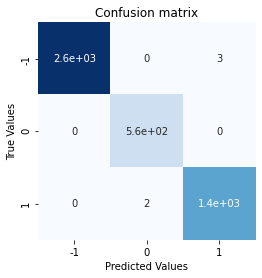

In [ ]:
rm1_train = get_accuracy_result(model1, 'model1', [X_train], y_train, 'train')

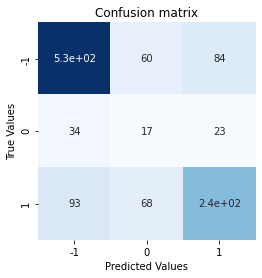

In [ ]:
rm1_test = get_accuracy_result(model1, 'model1', [X_test], y_test, 'test')

In [ ]:
rm1 = pd.concat([rm1_train, rm1_test])
rm1

,model,data,accuracy
0,model1,train,1.00
0,model1,test,0.69


In [ ]:
gc.collect()

8936

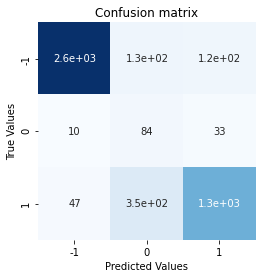

In [ ]:
rm2_train = get_accuracy_result(model2, 'model2', [tweets_train, X_train_ftrs_std], y_train, 'train')

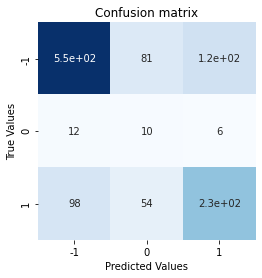

In [ ]:
rm2_test = get_accuracy_result(model2, 'model2', [tweets_test, X_test_ftrs_std], y_test, 'test')

In [ ]:
rm2 = pd.concat([rm2_train, rm2_test])
rm2

,model,data,accuracy
0,model2,train,0.85
0,model2,test,0.68


In [ ]:
result = pd.concat([rm1, rm2])
result

,model,data,accuracy
0,model1,train,1.00
0,model1,test,0.69
0,model2,train,0.85
0,model2,test,0.68
